NOTE for the instructor: magnitude, flux, distance modulus, calibration

# This notebook is intended to show how to calibrate an image, and measure an object's Magnitude!

## Overview from last time:

* Opening a fits image
* Plotting the image
* Finding all of the objects in the image

Let's start with all of the imports we will need today, along with our inline plotting `magic` function. 

In [18]:
#this gives us access to numpy as np, and matplotlib.pyplot as plt
%pylab inline

#Astronomical imports!... exotic
from astropy.io import fits
from astropy import wcs as wcs
import sep

Populating the interactive namespace from numpy and matplotlib


/Users/crisp/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['flag']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Opening an image
 <font color='blue'> Exercise: let's read an image as we learned in previous lectures and let's define the data and the header:
</font>

Hints: 
* our file is the same as last time `16335757.fits`
* we use the astropy.io function: `fits.open(filename)` to open the file
* this returns an HDU list, our data and header will be in the 0th item in this list (`list[0].data, list[0].header`)
* lets call them `img` and `header` respectively

<font color='blue'> Plot your img data! </font>
* using `plt.imshow(img)` 

### Now, let's plot a histogram of the image data, to see the range of its values

* We will use the matplotlib.pyplot (`plt`) histogram function: `plt.hist(x, bins)`
* Our data isn't in the correct format, we will convert it to a 1D list by using `img.flatten()`
* We will define it as having 100 bins as well

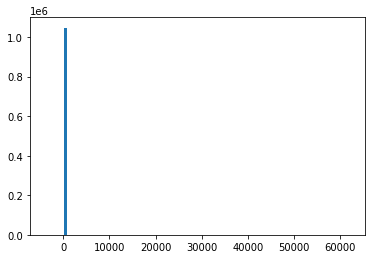

In [19]:
image_hist = plt.hist(img.flatten(), bins=100)

### Let's do it again, but this time constraining the range of the histogram  

* using <font color='blue'>range=(X,Y) </font> inside the `plt.hist()` method

* <font color='blue'>Can someone estimate values to put as the limits to the range? 0-10000? Less or more?</font>

In [20]:
image_hist = plt.hist(img.flatten(), bins=1000, range=(??,??))

SyntaxError: invalid syntax (<ipython-input-20-b5b0ea47599e>, line 1)

### Now that we have an idea where our data is, let's redo the plot with these parameters

* We can constrain our `plt.imshow()` by using the `vmin` and `vmax` parameters.
* <font color='blue'> Judging by the above histogram, what are some good values to use here?</font>

`imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=??, vmax=??)`

In [21]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=??, vmax=??)

SyntaxError: invalid syntax (<ipython-input-21-434a46781138>, line 2)

## Beautiful!


### Now lets find the position of all the stars in the image.

* For this we will use a package called: <font color='red'>sep</font> which was used last lecture
* We will have to define the background of the image, then use that information to locate the objects with `sep`


The 3 command we need to use are the following:
<br> <font color='blue'>  img = img.byteswap().newbyteorder()</font>
<br> <font color='blue'>  bkg = sep.Background(img)</font>
<br> <font color='blue'>  objects = sep.extract(img, thresh=20.0, err=bkg.globalrms, mask=None, minarea=10, clean=True, clean_param=1.0, segmentation_map=False)</font>

In [22]:
img = img.byteswap().newbyteorder() # magic command
bkg = sep.Background(img)
img_sub = img-bkg
objects = sep.extract(img, 
                      thresh=20.0, 
                      err=bkg.globalrms, 
                      mask=None, 
                      minarea=10, 
                      clean=True, 
                      clean_param=1.0, 
                      segmentation_map=False
                    )

ValueError: Input array with dtype '>f4' has non-native byte order. Only native byte order arrays are supported. To change the byte order of the array 'data', do 'data = data.byteswap().newbyteorder()'

### Now let's plot the objects that sep extracted

* objects is a NumPy structured array with many fields. We have seen the previous lecture where the source detections are stored. 

EXERCISE:
<font color='blue'> plot the extracted objects on the image </font>

Hints:
* our x,y values are stored in `objects['x'], objects['y']` respectively
* use plt.plot(??, ??, 'xr')

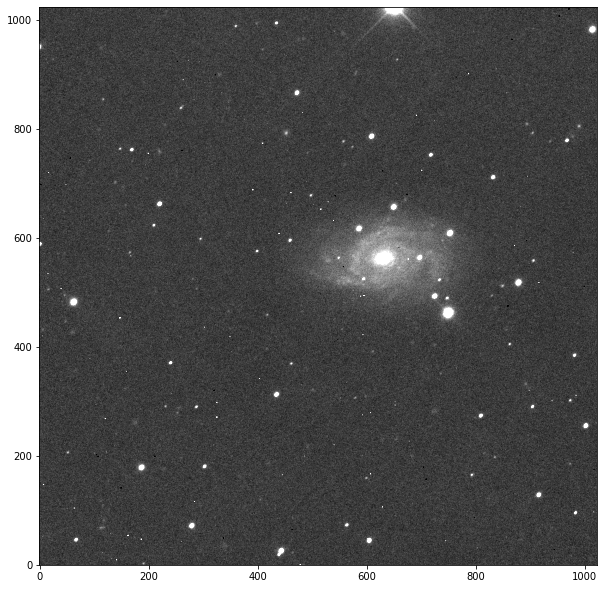

In [23]:
plt.figure(figsize=(10,12))
imgshow = plt.imshow(img, origin='lower', cmap='gray', vmin=200, vmax=400)
#plt.plot(.....)

# Photometry and Flux
Now what we want to do with these objects? We probably want to measure how much light is emitted by each of them

Let zoom on one of them. let's cut a small matrix of 40 x 40 pixels with one object in the center. to cut a region we should do  <font color='blue'> img[a:b,c:d] </font> with a,b,c,d the pixels (integer) at the edges of the small matrix. 

* let's do that for the element 10 of the object dictionary. `object['x'][10]` and `object['y'][10]`

* let's now plot the zoomed image!

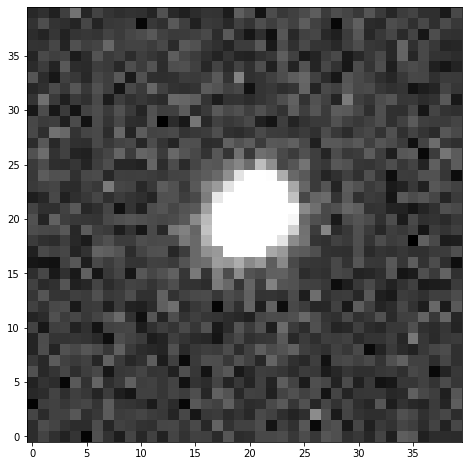

In [24]:
obj_10_y = int(objects['y'][10])
obj_10_x = int(objects['x'][10])

#The entire slice! -20 and + 20 all around this object from the image data
obj_10 = img[
    obj_10_y-20:obj_10_y+20,
    obj_10_x-20:obj_10_x+20
  ] 

fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)

## A philosphical question...
### How do we define where the star `begins` or `ends`??

Let's do a test!

I want to see the amount of flux at a given radius going out from the center of the circle. I will define the `edge` of my star where the amount of flux stops growing.

* We can utilize the `sep.sum_circle()` function to find the amount of flux inside a given radius
* Below, we iterate radii from 1-20 pixels from the center of our star, and plot the flux.
* here we use the subtracted img: `img_sub`

Text(0, 0.5, 'flux (counts)')

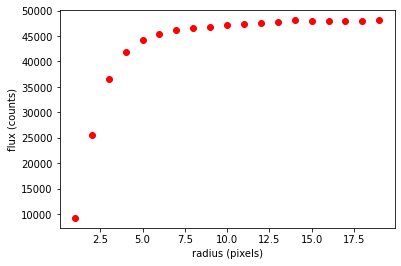

In [25]:
fluxvec = []
radiuscev = []
for radius in range(1,20):
    flux, fluxerr, flag = sep.sum_circle(img_sub, [objects['x'][10]], [objects['y'][10]],
                                         radius, err=bkg.globalrms, gain=1.0)
    #print(flux,fluxerr)
    fluxvec.append(flux)
    radiuscev.append(radius)

plt.plot(radiuscev,fluxvec,'or')
plt.xlabel('radius (pixels)')
plt.ylabel('flux (counts)')

Let's select the region to get all the counts of the object. We can use a circle.

<font color='blue'> From the plot above: How large should be the radius?</font>

EXERCISE:

* <font color='blue'> Lets plot 3 circles of different radii (8,10,12) about our circles to get an idea where the flux is coming from.</font>

Hint:

* To plot a circle you will first need to define a matplotlib `Circle` object and then add it to your ax patches like so:

```
c1 = Circle((x,y),radius, color='r', lw=4, fill=False)
ax.add_patch(c1)
```

* here (x,y) will be the center of our star (20, 20)
* lw - stands for linewidth, let's leave it at 4 pixels wide
* fill=False, we leave this at false. If true, it will plot an full colored circle, not just a ring.


In [26]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
imgshow = ax.imshow(obj_10, origin='lower', cmap='gray', vmin=200, vmax=400)
c1 = Circle(??, ??, ??)
ax.add_patch(c1)
#c2..and c3?...

SyntaxError: invalid syntax (<ipython-input-26-85744f59a281>, line 3)

### Now that we have defined the "Edge" of our star, Lets get its flux!

EXERCISE: <font color='blue'>Measuring Flux of our object</font>
* using the sep.sum_circle() method from above obtain the flux and error from our 10th element object
* `flux, fluxerr, flag = sep.sum_circle(img_sub, [x], [y], radius, err=bkg.globalrms, gain=1.0)`


In [27]:
flux, fluxerr, flag = sep.sum_circle(??,??,??)

print(flux)

SyntaxError: invalid syntax (<ipython-input-27-4f383470c697>, line 1)

### To clarify:

* What we have just measured is the number of counts within a radius of ?? pixel(s) for one object we selected in the image. 
* How do we use this measurement in astronomy? We usually convert this measurment in magnitude and if we know how our telescope is performing, we know how bright a star appear to be. How bright actually is depends on how far the star is. 

### Magnitudes!
* <font color='blue'> Let's first convert the flux in magnitudes. </font> 
* The equation we will use is `inst_mag = -2.5*np.log10(flux)`
* print it out!

### We are not done yet...

* We still need to transform this 'instrumental magnitude' into its actual apparent magnitude. This value will actually mean something... astronomically

* In order to do this primary calibration, we need to know the apparent magnitude of at least one object in the field... a <b>Standard Star</b>! 

* We need to measure its instrumental magnitude and subtract it from its known apparent magnitude and obtain what we call the "<b>Zeropoint</b>"

* Once we have the zeropoint, we can measure the magnitudes of any object in the image by adding it to the instrumental magnitude!

EXERCISE <font color='blue'> Measuring the zeropoint </font>

* <font color='blue'> I know the apparent magnitude of the 9th element of our objects is 15, using the code above calculate the zeropoint for our image</font>

HINTS:

* Copy the code above and calculate inst_mag using the sep.sum_circle() function on the 9th element of our objects list, you can keep the radius at 10.
* `zeropoint = app_mag - inst_mag; (app_mag = 15)`

### The final goal! 

* <font color='blue'> Now that you know the zeropoint of the image, calculate the apparent magnitude of our original Star!</font>

HINT:

* `app_mag = zeropoint + inst_mag`


# Distance modulus

* We have learned that knowing the apparent and absolute magnitudes can give us a distance to the source (Distance Modulus).

* `distance_modulus = apparent_mag - absolute_mag`

* <font color='blue'>What if we already knew the Distance Modulus to our image above? What information could we get from what we learned today?</font>

* <i>.. pause for participation...</i>

* That's right! We can find the absolute magnitude! This is very important for initial supernovae discoveries. Knowing the absolute magnitude of a young SN can give us roughly an idea of its type.

* <font color='blue'> If we knew the distance modulus to our image as: `30mag`. What would be the absolute magnitude to our original star? </font>